In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score, KFold
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import lightgbm as lgb
import optuna
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv


**Постановка бизнес-задачи: Предсказание оценки студента на основе различных характеристик** 

**Постановка ML-задачи: Линейная регрессия**

**Оптимизируемая метрика:**

В данной задаче если предсказать оценку меньшую от той, которую студент получит, то это его или других заинтересованных лиц не особо расстроит, скорее обрадует, однако если модель предскажет студенту, например, 90 баллов, а он получит лишь 60, то эта ситуация более печальная.
Поэтому в качестве метрики была выбрана квантильная функция потерь


In [3]:
df = pd.read_csv('/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv')
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [4]:
df.sample(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
4647,20,78,Medium,High,Yes,8,64,Medium,Yes,2,High,Medium,Private,Positive,2,No,High School,Moderate,Female,68
2416,23,72,Medium,High,No,8,87,Low,Yes,3,Medium,Low,Public,Neutral,3,No,High School,Near,Male,67
6550,20,79,Medium,Medium,Yes,8,71,Medium,Yes,1,Medium,High,Public,Neutral,3,No,College,Near,Female,68
5364,19,68,Medium,Low,Yes,8,75,Low,Yes,1,Medium,Medium,Private,Neutral,4,No,Postgraduate,Near,Male,64
4314,18,66,High,Medium,Yes,6,68,Low,No,1,Medium,High,Public,Positive,3,Yes,High School,Far,Male,61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [6]:
df.shape

(6607, 20)

In [7]:
df.dtypes

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

In [8]:
cat_columns = df.select_dtypes(include='object').columns.tolist()
num_columns = df.select_dtypes(exclude='object').columns.tolist()

In [9]:
df[num_columns].describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [10]:
df[cat_columns].describe()

,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Motivation_Level,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
count,6607,6607,6607,6607,6607,6607,6529,6607,6607,6607,6517,6540,6607
unique,3,3,2,3,2,3,3,2,3,2,3,3,2
top,Medium,Medium,Yes,Medium,Yes,Low,Medium,Public,Positive,No,High School,Near,Male
freq,3362,3319,3938,3351,6108,2672,3925,4598,2638,5912,3223,3884,3814


In [11]:
df[num_columns].isna().sum()

Hours_Studied        0
Attendance           0
Sleep_Hours          0
Previous_Scores      0
Tutoring_Sessions    0
Physical_Activity    0
Exam_Score           0
dtype: int64

In [12]:
df[cat_columns].isna().sum()

Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Motivation_Level               0
Internet_Access                0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
dtype: int64

In [13]:
df['Teacher_Quality'].value_counts(dropna=False)

Teacher_Quality
Medium    3925
High      1947
Low        657
NaN         78
Name: count, dtype: int64

In [14]:
df['Parental_Education_Level'].value_counts(dropna=False)

Parental_Education_Level
High School     3223
College         1989
Postgraduate    1305
NaN               90
Name: count, dtype: int64

In [15]:
df['Distance_from_Home'].value_counts(dropna=False)

Distance_from_Home
Near        3884
Moderate    1998
Far          658
NaN           67
Name: count, dtype: int64

**Пропуски в категориальных колонках можно заполнить, например, самым частым значением (после разбиения выборки)**

In [16]:
# df['Distance_from_Home'].fillna(df['Distance_from_Home'].mode()[0], inplace=True)
# df['Parental_Education_Level'].fillna(df['Parental_Education_Level'].mode()[0], inplace=True)
# df['Teacher_Quality'].fillna(df['Teacher_Quality'].mode()[0], inplace=True)

In [17]:
df[cat_columns].isna().sum()

Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Motivation_Level               0
Internet_Access                0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
dtype: int64

**Обработка категориальных фичей**

In [18]:
cat_columns

['Parental_Involvement',
 'Access_to_Resources',
 'Extracurricular_Activities',
 'Motivation_Level',
 'Internet_Access',
 'Family_Income',
 'Teacher_Quality',
 'School_Type',
 'Peer_Influence',
 'Learning_Disabilities',
 'Parental_Education_Level',
 'Distance_from_Home',
 'Gender']

In [19]:
for col in cat_columns:
    print(col)
    print(df[col].unique())

Parental_Involvement
['Low' 'Medium' 'High']
Access_to_Resources
['High' 'Medium' 'Low']
Extracurricular_Activities
['No' 'Yes']
Motivation_Level
['Low' 'Medium' 'High']
Internet_Access
['Yes' 'No']
Family_Income
['Low' 'Medium' 'High']
Teacher_Quality
['Medium' 'High' 'Low' nan]
School_Type
['Public' 'Private']
Peer_Influence
['Positive' 'Negative' 'Neutral']
Learning_Disabilities
['No' 'Yes']
Parental_Education_Level
['High School' 'College' 'Postgraduate' nan]
Distance_from_Home
['Near' 'Moderate' 'Far' nan]
Gender
['Male' 'Female']


Значения стоблцов Parental_Involvement,Access_to_Resources,Motivation_Level,Family_Income,Teacher_Quality,Peer_Influence,Parental_Education_Level,Distance_from_Home  имеют порядок, поэтому можно заменить их при помощи метода **OrdinalEncoding**

Значения остальных столбцов достаточно заменить при помощи **OHE**

In [20]:
ordinal_enc_cols = ['Parental_Involvement','Access_to_Resources','Motivation_Level','Family_Income',
                  'Teacher_Quality','Peer_Influence','Parental_Education_Level','Distance_from_Home']
ohe_cols = ['Extracurricular_Activities','Internet_Access','School_Type','Learning_Disabilities','Gender']

**OHE**

In [21]:
ohe = OneHotEncoder(sparse=False, drop='first') 
ohe_data = ohe.fit_transform(df[ohe_cols])
ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_cols))
df = pd.concat([df.drop(columns=ohe_cols), ohe_df], axis=1)

**ORDINAL ENCODING**

In [22]:
ordinal_mappings = {
    'Parental_Involvement': {'Low': 1, 'Medium': 2, 'High': 3},
    'Access_to_Resources': {'Low': 1, 'Medium': 2, 'High': 3},
    'Motivation_Level': {'Low': 1, 'Medium': 2, 'High': 3},
    'Family_Income': {'Low': 1, 'Medium': 2, 'High': 3},
    'Teacher_Quality': {'Low': 1, 'Medium': 2, 'High': 3},
    'Peer_Influence': {'Negative': 1, 'Neutral': 2, 'Positive': 3},
    'Parental_Education_Level': {'High School': 1, 'College': 2, 'Postgraduate': 3},
    'Distance_from_Home': {'Near': 1, 'Moderate': 2, 'Far': 3}
}

for col, mapping in ordinal_mappings.items():
    df[col] = df[col].map(mapping)

Новые названия категориальных признаков

In [23]:
cat_columns = ohe_df.columns.tolist()
cat_columns.extend(ordinal_enc_cols)

In [24]:
cat_columns

['Extracurricular_Activities_Yes',
 'Internet_Access_Yes',
 'School_Type_Public',
 'Learning_Disabilities_Yes',
 'Gender_Male',
 'Parental_Involvement',
 'Access_to_Resources',
 'Motivation_Level',
 'Family_Income',
 'Teacher_Quality',
 'Peer_Influence',
 'Parental_Education_Level',
 'Distance_from_Home']

In [25]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Peer_Influence,Physical_Activity,Parental_Education_Level,Distance_from_Home,Exam_Score,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
0,23,84,1,3,7,73,1,0,1,2.0,3,3,1.0,1.0,67,0.0,1.0,1.0,0.0,1.0
1,19,64,1,2,8,59,1,2,2,2.0,1,4,2.0,2.0,61,0.0,1.0,1.0,0.0,0.0
2,24,98,2,2,7,91,2,2,2,2.0,2,4,3.0,1.0,74,1.0,1.0,1.0,0.0,1.0
3,29,89,1,2,8,98,2,1,2,2.0,1,4,1.0,2.0,71,1.0,1.0,1.0,0.0,1.0
4,19,92,2,2,6,65,2,3,2,3.0,2,4,2.0,1.0,70,1.0,1.0,1.0,0.0,0.0


Все категориальные признаки переведены в числовой формат, пропуски обработаны. Теперь можно приступить к визуальному анализу данных

# **EDA**

In [26]:
df[num_columns].describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


Распределение целевой переменной близко к нормальному, с длинным правым хвостом

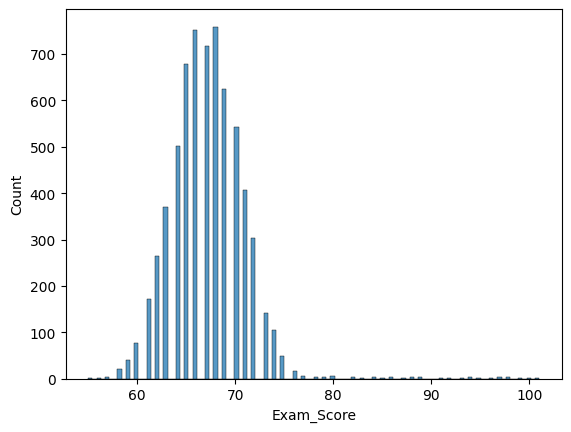

In [27]:
sns.histplot(x=df['Exam_Score']);

Распределения числовых признаков

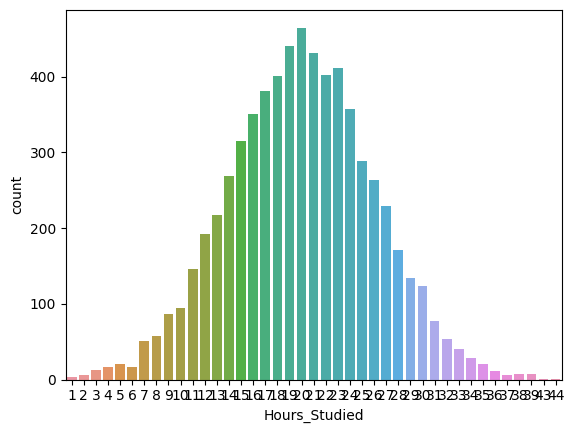

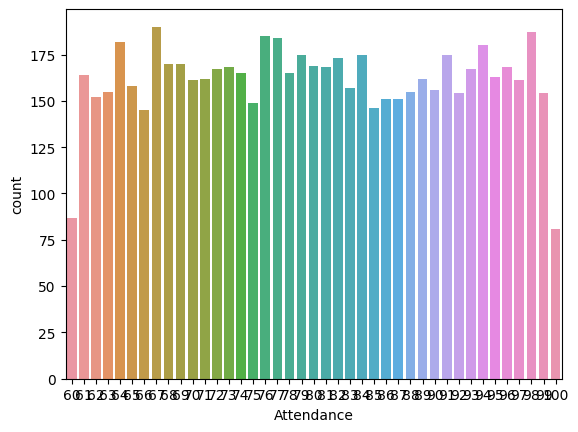

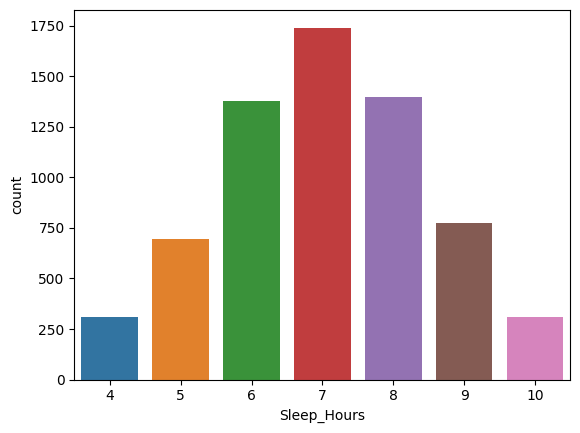

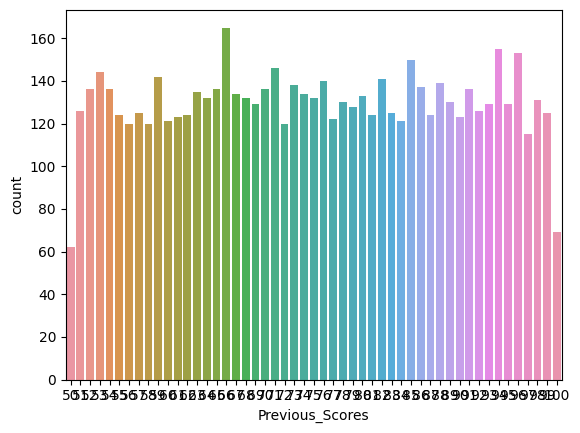

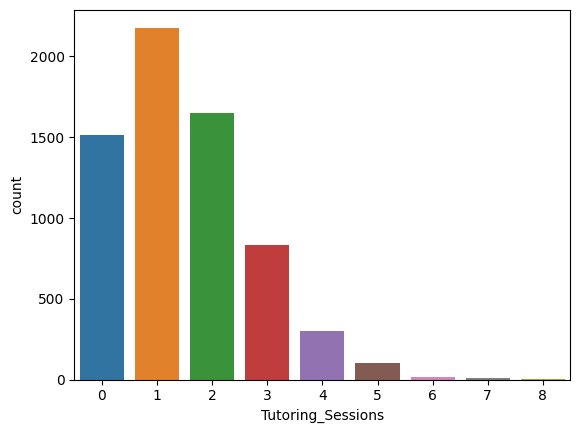

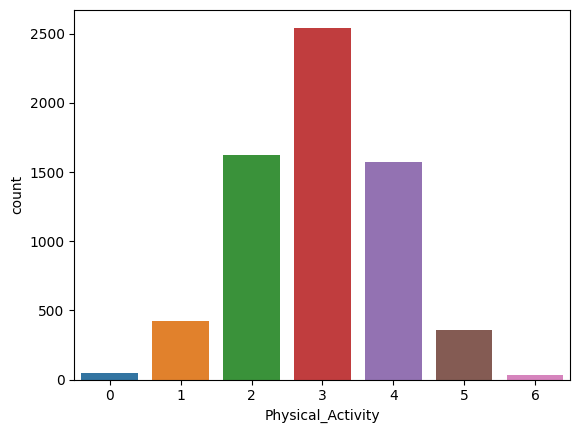

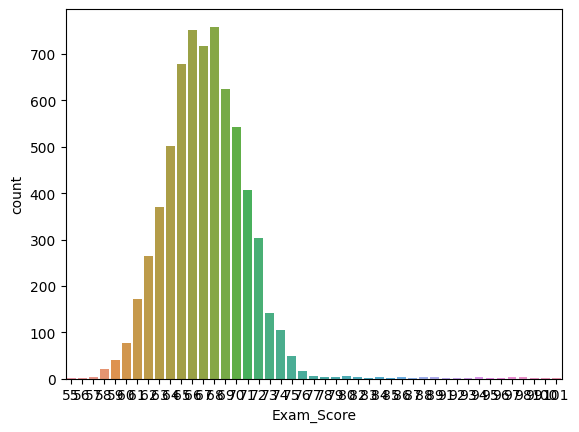

In [28]:
for col in df[num_columns]:
    if col!='ExamScore':
        sns.countplot(x=df[col], data=df)
        plt.show()

Корреляция признаков между собой

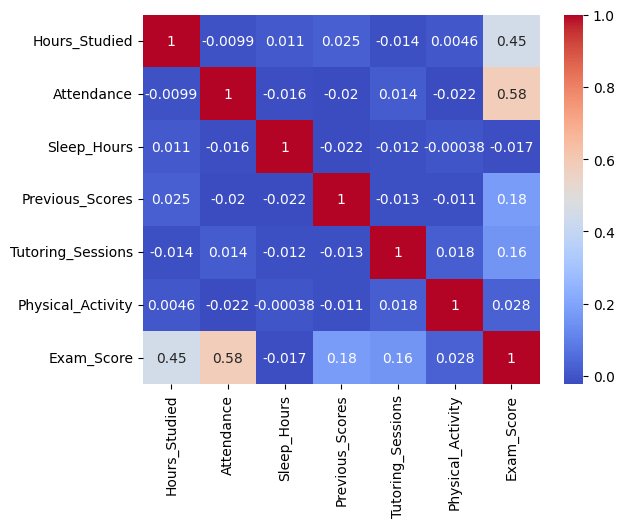

In [29]:
sns.heatmap(df[num_columns].corr(), annot=True, cmap='coolwarm')
plt.show()

Большая корреляция лишь у двух признаков и то с целевой переменной, то есть они привнесут в модель "больший вклад", остальные признаки почти не имеют линейной зависимости между собой


Попарные графики признаков с целевой переменной

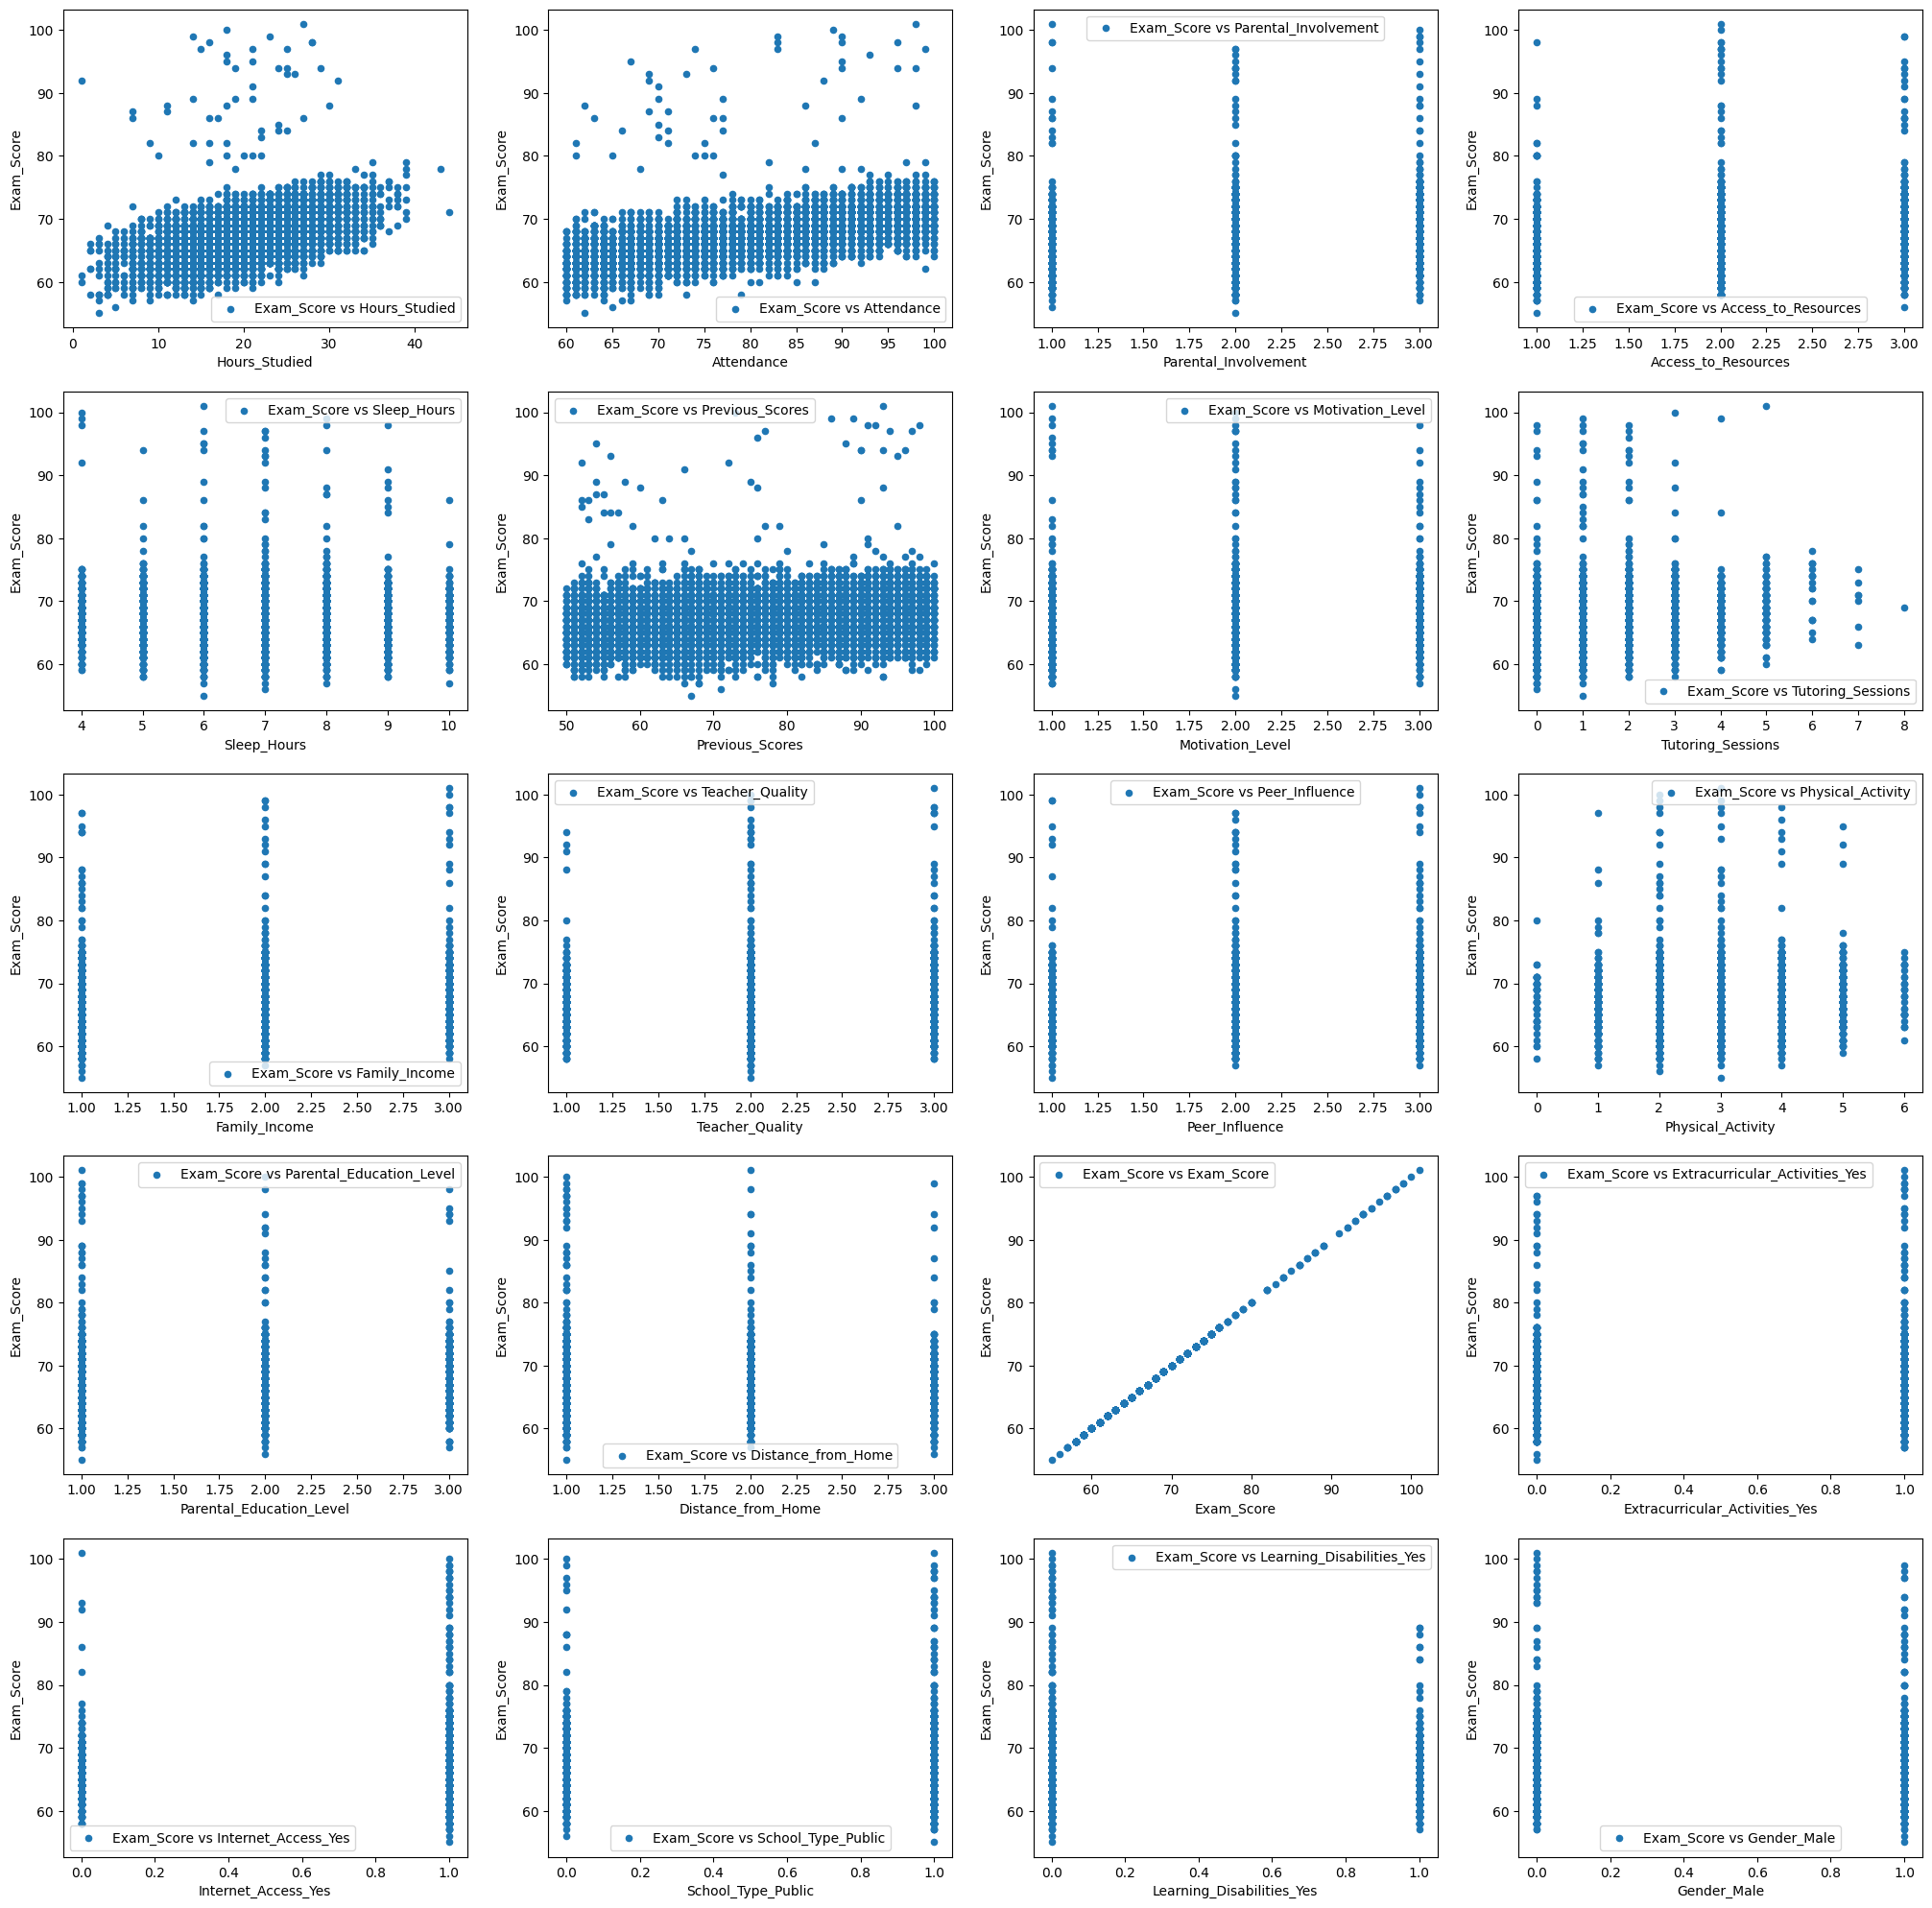

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25, 25))
for idx, feature in enumerate(df.columns):
    df.plot(feature, "Exam_Score", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4], label=f'Exam_Score vs {feature}')

По графикам можно заметить небольшую линейную зависимость ExamScore от Previous_Scores, Attendance, Hours_Studied, что логично. Из категориальных признаков можно обратить внимание на Internet_Access_Yes: Высокие оценки чаще у тех, у кого есть доступ к интернету, однако здесь может быть дисбаланс в количестве студентов с доступом:

In [31]:
df['Internet_Access_Yes'].value_counts()

Internet_Access_Yes
1.0    6108
0.0     499
Name: count, dtype: int64

**ВЫБРОСЫ**

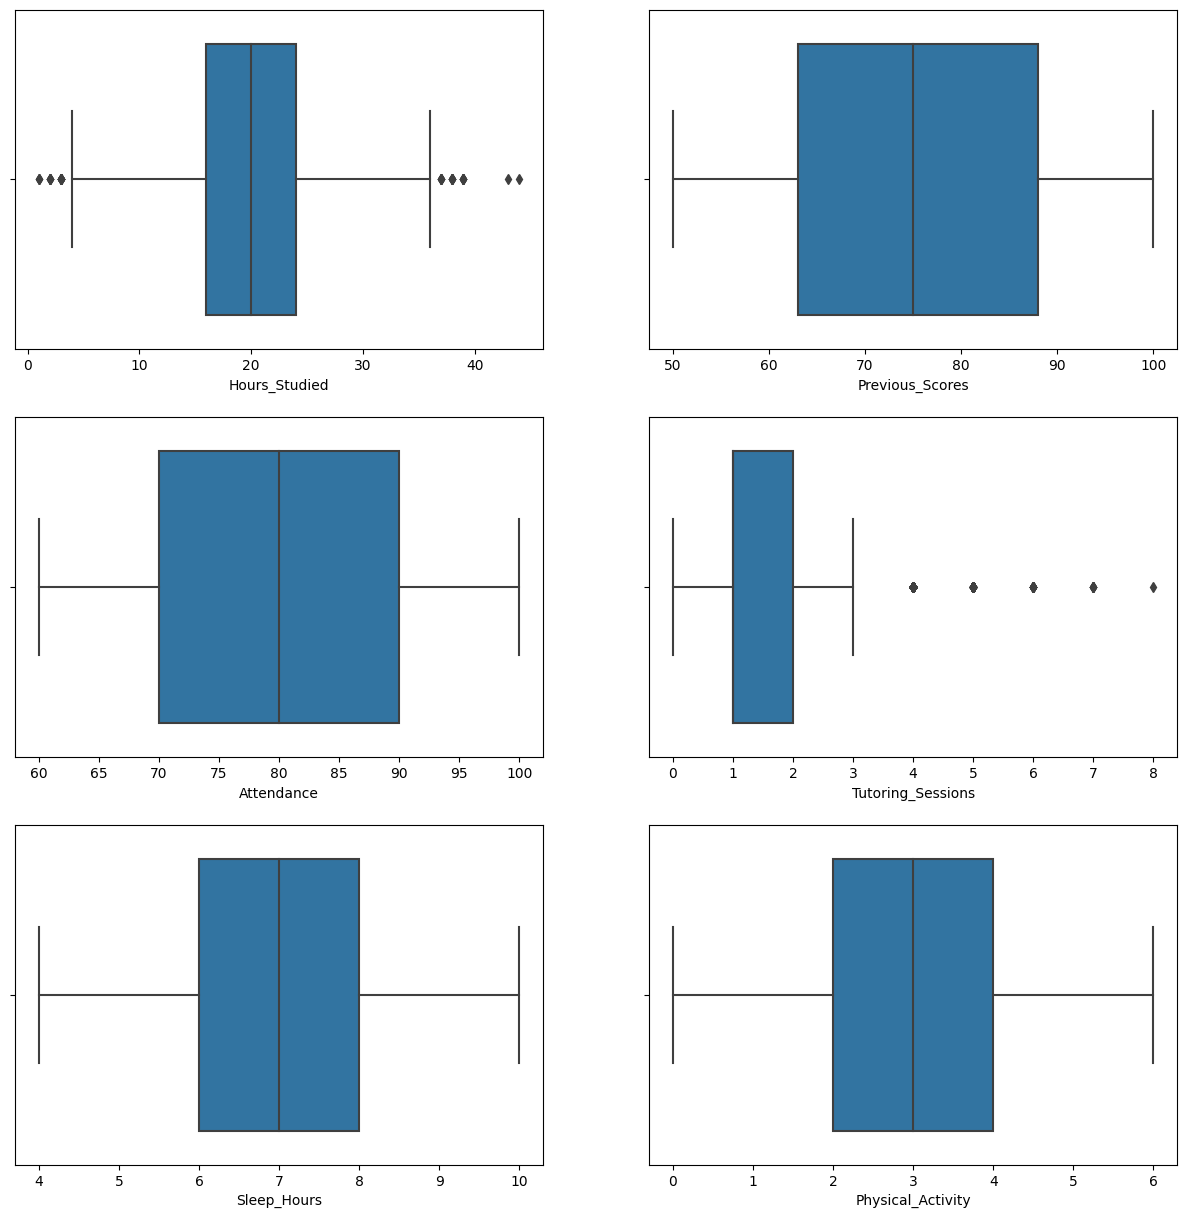

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
count = 0
for idx, feature in enumerate(df[num_columns].columns):
    if feature!='Exam_Score':
        sns.boxplot(x=df[feature], ax=axes[count % 3, count // 3])
        count += 1

Хоть некоторые бохплоты и показывают значения, выходящие за усики, назвать их выбросами нельзя. Так как значения колонок Hours_Studied, Tutoring_Seddion интерпретируемые, нельзя сказать, что кол-во учебных часов больше или меньше основной массы это явный выброс, ровно также, как и кол-во занятий с репетитором, которое к тому же имеет обратную зависимость с Exam_Score (см график выше) Поэтому эти значения выбрасывать нельзя, они важны для модели

# HM 2


Все "импорты" в начале файла

In [33]:
RANDOM_STATE = 42

In [34]:
X = df.drop(['Exam_Score'],axis=1)
y = df['Exam_Score']

Масштабирование данных может помочь в будущем, однако применять его стоит лишь к изначально числовых признакам, для преобразованных категориальных это может нарушить порядок
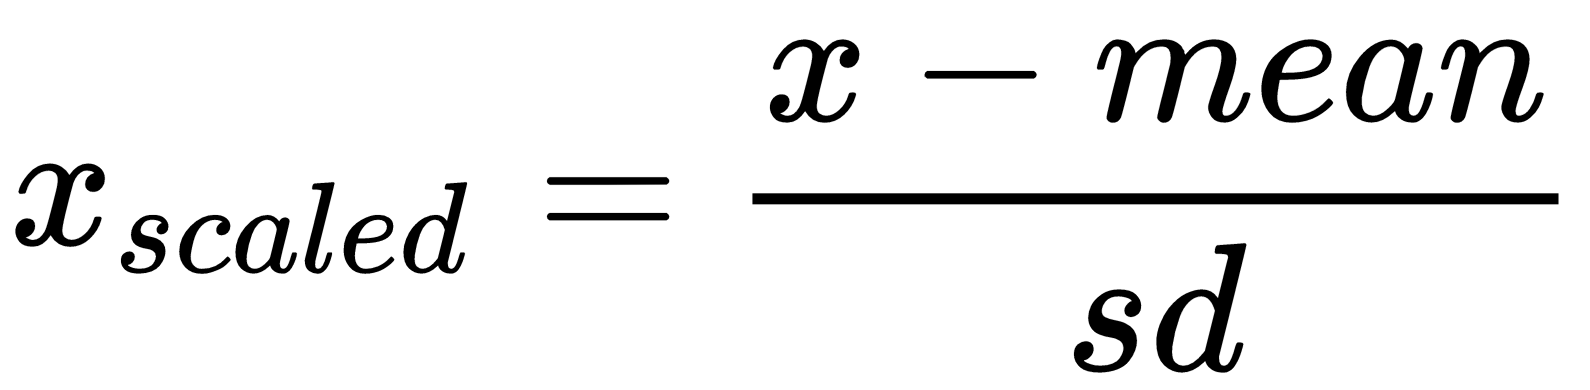
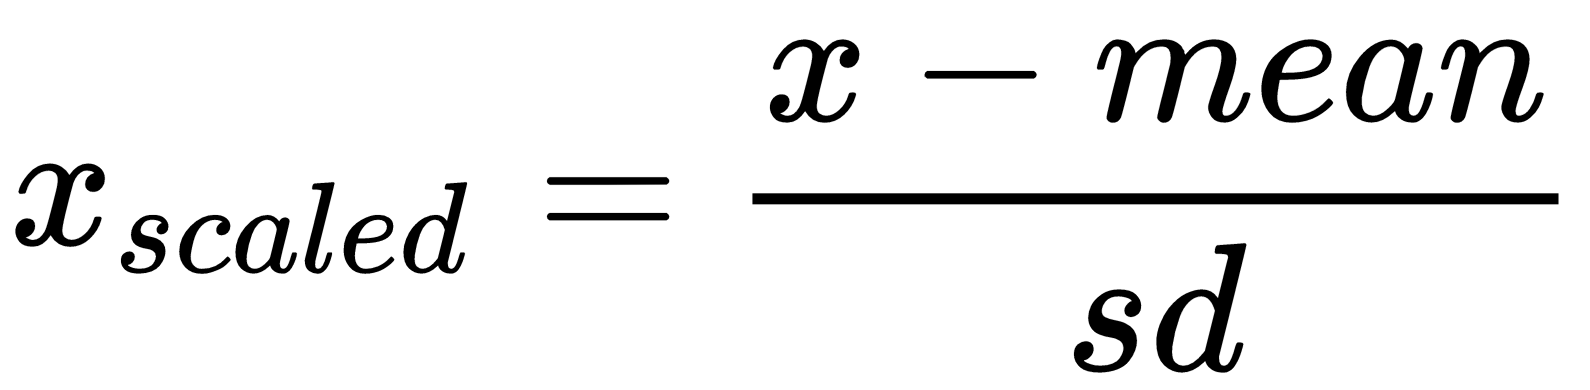

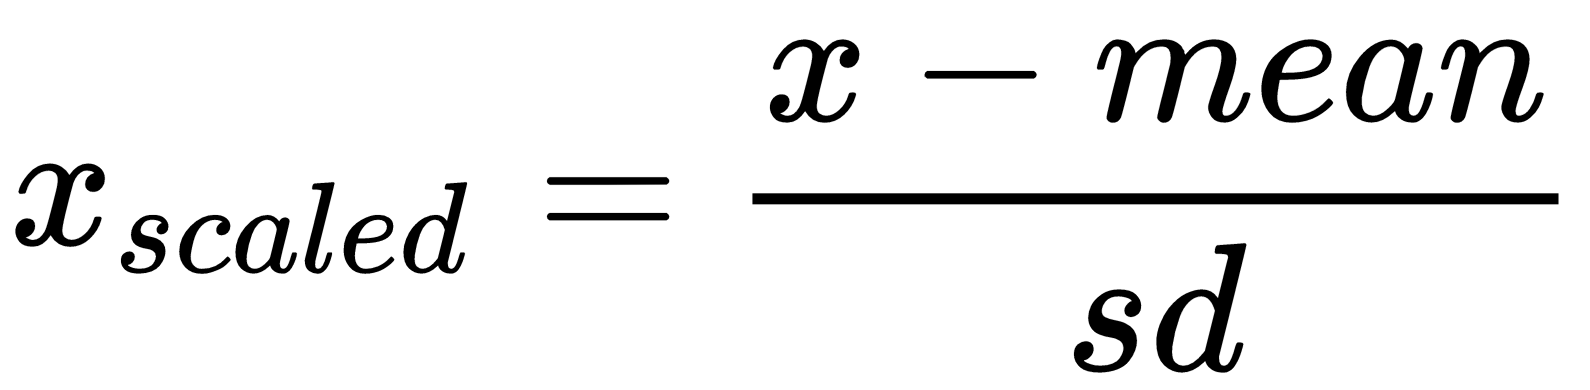
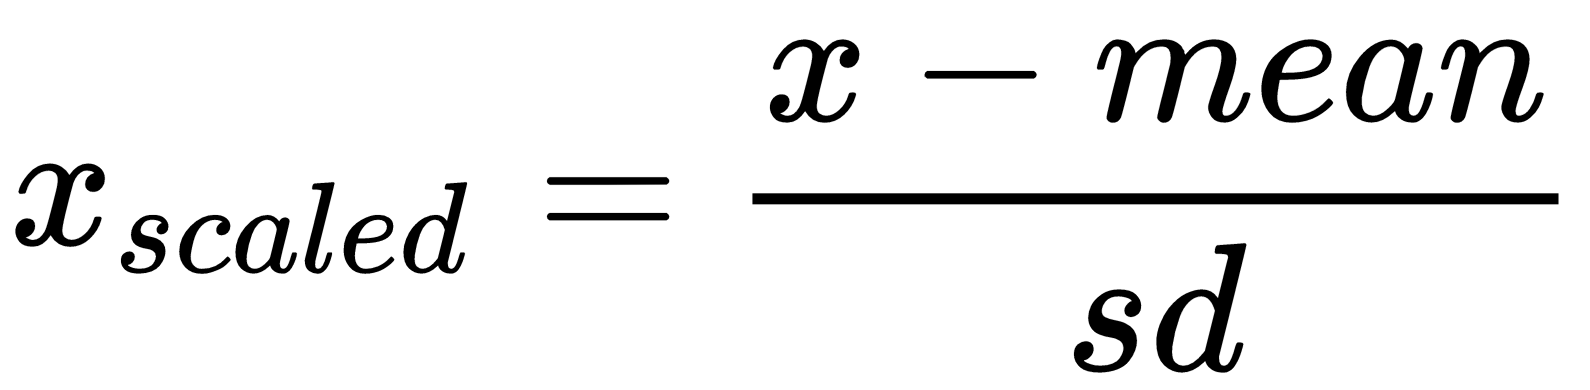

In [35]:
X.columns[~X.columns.isin(cat_columns)].tolist()
cat_columns

['Extracurricular_Activities_Yes',
 'Internet_Access_Yes',
 'School_Type_Public',
 'Learning_Disabilities_Yes',
 'Gender_Male',
 'Parental_Involvement',
 'Access_to_Resources',
 'Motivation_Level',
 'Family_Income',
 'Teacher_Quality',
 'Peer_Influence',
 'Parental_Education_Level',
 'Distance_from_Home']

In [36]:
num_columns = X.columns[~X.columns.isin(cat_columns)].tolist()

Разбиение на трейн/тест/вал

In [37]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

scaler = MinMaxScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])
X_val[num_columns] = scaler.transform(X_val[num_columns])

In [38]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4624, 19)
(992, 19)
(991, 19)


In [39]:
X_train.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Peer_Influence,Physical_Activity,Parental_Education_Level,Distance_from_Home,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
2173,0.476190,0.225,2,2,0.833333,0.60,3,0.250,2,3.0,3,0.833333,2.0,1.0,1.0,1.0,1.0,0.0,1.0
113,0.809524,0.975,3,3,0.500000,0.70,1,0.250,2,3.0,2,0.333333,3.0,1.0,1.0,1.0,0.0,0.0,0.0
5593,0.500000,0.275,2,2,0.666667,0.12,1,0.000,2,3.0,2,0.333333,3.0,1.0,1.0,1.0,1.0,0.0,1.0
6386,0.452381,0.275,3,3,0.333333,0.60,2,0.250,3,1.0,3,0.500000,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1438,0.523810,0.775,3,2,0.333333,0.86,2,0.375,1,1.0,2,0.500000,1.0,2.0,0.0,1.0,1.0,0.0,0.0


После разбиение на трейн/тест/вал можем заполнить пропуски, найденные во время EDA, посчитанной модой/медианой и т.д. на тренировочной выборке.

In [40]:
X_train[cat_columns].isna().sum()

Extracurricular_Activities_Yes     0
Internet_Access_Yes                0
School_Type_Public                 0
Learning_Disabilities_Yes          0
Gender_Male                        0
Parental_Involvement               0
Access_to_Resources                0
Motivation_Level                   0
Family_Income                      0
Teacher_Quality                   52
Peer_Influence                     0
Parental_Education_Level          60
Distance_from_Home                46
dtype: int64

In [41]:
X_test[cat_columns].isna().sum()


Extracurricular_Activities_Yes     0
Internet_Access_Yes                0
School_Type_Public                 0
Learning_Disabilities_Yes          0
Gender_Male                        0
Parental_Involvement               0
Access_to_Resources                0
Motivation_Level                   0
Family_Income                      0
Teacher_Quality                   14
Peer_Influence                     0
Parental_Education_Level          13
Distance_from_Home                12
dtype: int64

In [42]:
X_val[cat_columns].isna().sum()

Extracurricular_Activities_Yes     0
Internet_Access_Yes                0
School_Type_Public                 0
Learning_Disabilities_Yes          0
Gender_Male                        0
Parental_Involvement               0
Access_to_Resources                0
Motivation_Level                   0
Family_Income                      0
Teacher_Quality                   12
Peer_Influence                     0
Parental_Education_Level          17
Distance_from_Home                 9
dtype: int64

In [43]:
X_test['Distance_from_Home'].fillna(X_train['Distance_from_Home'].mode()[0], inplace=True)
X_test['Parental_Education_Level'].fillna(X_train['Parental_Education_Level'].mode()[0], inplace=True)
X_test['Teacher_Quality'].fillna(X_train['Teacher_Quality'].mode()[0], inplace=True)
X_val['Distance_from_Home'].fillna(X_train['Distance_from_Home'].mode()[0], inplace=True)
X_val['Parental_Education_Level'].fillna(X_train['Parental_Education_Level'].mode()[0], inplace=True)
X_val['Teacher_Quality'].fillna(X_train['Teacher_Quality'].mode()[0], inplace=True)
X_train['Distance_from_Home'].fillna(X_train['Distance_from_Home'].mode()[0], inplace=True)
X_train['Parental_Education_Level'].fillna(X_train['Parental_Education_Level'].mode()[0], inplace=True)
X_train['Teacher_Quality'].fillna(X_train['Teacher_Quality'].mode()[0], inplace=True)

In [44]:
X_train[cat_columns].isna().sum()

Extracurricular_Activities_Yes    0
Internet_Access_Yes               0
School_Type_Public                0
Learning_Disabilities_Yes         0
Gender_Male                       0
Parental_Involvement              0
Access_to_Resources               0
Motivation_Level                  0
Family_Income                     0
Teacher_Quality                   0
Peer_Influence                    0
Parental_Education_Level          0
Distance_from_Home                0
dtype: int64

In [45]:
X_test[cat_columns].isna().sum()


Extracurricular_Activities_Yes    0
Internet_Access_Yes               0
School_Type_Public                0
Learning_Disabilities_Yes         0
Gender_Male                       0
Parental_Involvement              0
Access_to_Resources               0
Motivation_Level                  0
Family_Income                     0
Teacher_Quality                   0
Peer_Influence                    0
Parental_Education_Level          0
Distance_from_Home                0
dtype: int64

In [46]:
X_val[cat_columns].isna().sum()

Extracurricular_Activities_Yes    0
Internet_Access_Yes               0
School_Type_Public                0
Learning_Disabilities_Yes         0
Gender_Male                       0
Parental_Involvement              0
Access_to_Resources               0
Motivation_Level                  0
Family_Income                     0
Teacher_Quality                   0
Peer_Influence                    0
Parental_Education_Level          0
Distance_from_Home                0
dtype: int64

In [47]:
def quantile_loss(y_true, y_pred, quantile):
  errors = y_true - y_pred
  loss = np.mean(np.maximum(quantile * errors, (quantile - 1) * errors))
  return loss

quan = 0.6 # от 0 до 1, ближе к 1 больше штраф за отриц предсказание
baseline_prediction = np.mean(y_train)
baseline_quantile_loss = quantile_loss(y_test, np.full(len(y_test), baseline_prediction), quan)
print(f"Квантильная функция потерь константного предсказания: {baseline_quantile_loss}")


Квантильная функция потерь константного предсказания: 1.4335227669103692


In [48]:
model = QuantileRegressor(quantile=quan,solver='highs', alpha=0.001)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

quantile_loss_value = quantile_loss(y_test, y_pred, quan)
print(f"Квантильная функция потерь линейной регрессии (alpha={quan}): {quantile_loss_value}")

Квантильная функция потерь линейной регрессии (alpha=0.6): 0.2180943991436293


In [49]:
y_pred_val = model.predict(X_val)
quantile_loss_value = quantile_loss(y_val, y_pred_val, quan)
print(f"Квантильная функция потерь линейной регрессии (alpha={quan}): {quantile_loss_value}")

Квантильная функция потерь линейной регрессии (alpha=0.6): 0.20215081220097197


# HM 3

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

scaler = MinMaxScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

X_test['Distance_from_Home'].fillna(X_train['Distance_from_Home'].mode()[0], inplace=True)
X_test['Parental_Education_Level'].fillna(X_train['Parental_Education_Level'].mode()[0], inplace=True)
X_test['Teacher_Quality'].fillna(X_train['Teacher_Quality'].mode()[0], inplace=True)
X_train['Distance_from_Home'].fillna(X_train['Distance_from_Home'].mode()[0], inplace=True)
X_train['Parental_Education_Level'].fillna(X_train['Parental_Education_Level'].mode()[0], inplace=True)
X_train['Teacher_Quality'].fillna(X_train['Teacher_Quality'].mode()[0], inplace=True)


**Optuna + kfold**

Была выбрана модель lgbmregressor, так как строится множество деревьев и каждое следующее минимизирует ошибку прошлых, что должно помочь найти лучшее решение чем QuantileRegressor

In [51]:
def quantile_loss(y_true, y_pred, alpha):
    errors = y_true - y_pred
    loss = np.mean(np.maximum(alpha * errors, (alpha - 1) * errors))
    return loss

quan = 0.6
quantile_scorer = make_scorer(quantile_loss, greater_is_better=False, alpha=quan)

def objective(trial):
    params = {
        'objective': 'quantile', # Quantile loss для регрессии
        'metric': 'quantile', # метрика та же самая
        'alpha': 0.6, # смещение для квантильной ф-ии потерь
        'boosting_type': 'gbdt', # градиентный бустинг на дереве решений
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2), # "скорость" или шаг для градиента обучения
        'n_estimators': trial.suggest_int('n_estimators', 100, 300), # кол-во деревьев исплользуемое в обучении
        'num_leaves': trial.suggest_int('num_leaves', 20, 100), # макс кол-во листьев (для меньшего датасета меньше листьев)
        'max_depth': trial.suggest_int('max_depth', 3, 10), # макс глубина дерева, чтобы избежать переобучения
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50), # мин кол-во экземпляров в листе
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0), # выбор признаков для обучения
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 1.0), # l1 регуляризация
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 1.0), # l2 регуляризация
        'verbosity': -1 # чтоб вывода меньше было
}

    model = lgb.LGBMRegressor(**params)
    kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_train, y_train, scoring=quantile_scorer, cv=kf)
    mean_score = -np.mean(scores)
    return mean_score

study = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARN)
study.optimize(objective, n_trials=100)
print("Best trial optuna:")
print(f"  QuantileLoss: {study.best_value}")
print(f"  Params: {study.best_params}")

optuna_params = study.best_params
optuna_params.update({'objective': 'quantile', 'metric': 'quantile', 'alpha': 0.6})

[I 2024-12-03 13:55:14,625] A new study created in memory with name: no-name-03d0b2d1-dae2-4353-964f-2e8c4b528fe6


Best trial optuna:
  QuantileLoss: 0.28436402402499483
  Params: {'learning_rate': 0.17645956304155347, 'n_estimators': 300, 'num_leaves': 42, 'max_depth': 3, 'min_data_in_leaf': 39, 'feature_fraction': 0.6343383153715733, 'lambda_l1': 0.1595639336345499, 'lambda_l2': 0.006408375112441188}


**GridSearch & RandomSearch**

Невообразимо долго считает, один раз удалось посчитать, но ядро умерло и всё потерялось

In [53]:

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'num_leaves': [20, 40, 60, 100],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.05, 0.1, 0.15],
#     'min_data_in_leaf': [10, 20, 30],
#     'feature_fraction': [0.6, 0.8, 1.0],
#     'lambda_l1': [1e-3, 0.1, 1.0],
#     'lambda_l2': [1e-3, 0.1, 1.0],
#     'verbosity': [-1]
# }

# grid_search = GridSearchCV(lgb.LGBMRegressor(), param_grid, cv=5, scoring=quantile_scorer, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print("Best GridSearch result:")
# print(f"  Best score: {grid_search.best_score_}")
# print(f"  Best params: {grid_search.best_params_}")


# random_search = RandomizedSearchCV(lgb.LGBMRegressor(), param_distributions=param_grid, n_iter=20, cv=5, scoring=quantile_scorer, n_jobs=-1, random_state=RANDOM_STATE)
# random_search.fit(X_train, y_train)
# print("Best RandomizedSearch result:")
# print(f"  Best score: {random_search.best_score_}")
# print(f"  Best params: {random_search.best_params_}")


**Выбор лучших параметров**

In [55]:
# best_model_params = min(
#     [(study.best_value, optuna_params), (abs(grid_search.best_score_), grid_search.best_params_), (abs(random_search.best_score_), random_search.best_params_)],
#     key=lambda x: x[0]
# )[1]
best_model_params = optuna_params
final_model = lgb.LGBMRegressor(**best_model_params
                                ,verbosity=-1)
final_model.fit(X_train, y_train)
predictions = final_model.predict(X_test)

quantile_loss_value = quantile_loss(y_test, predictions, quan)
print(f"""Квантильная функция потерь на валидационной выборке LGBMRegressor с лучшими параметрами 
полученными при помощи Grid/Random Search и optuna с применением cross-validation: loss =  {quantile_loss_value}""")

Квантильная функция потерь на валидационной выборке LGBMRegressor с лучшими параметрами 
полученными при помощи Grid/Random Search и optuna с применением cross-validation: loss =  0.25566236156166605


К сожалению, не удалось подобрать гиперпараметры для поиска параметров для lgbm, чтобы найти лучшее решение, чем базовое полученное в домашней работе 2.Наилучшие параметры получились при RandomizeSearch, так как квантильная функция потерь не симметрична относительно 0

**Permutation importances**

Признаки Hours_Studied & Attendancе наиболее важные, так как лишь при их перестановке (какого-то одного) качество модели сильно падает. Прзинаки пола, типа школы и кол-во часов сна при таком масштабе почти нулевые или нулевые, то есть их вклад в прогноз минимальнейший

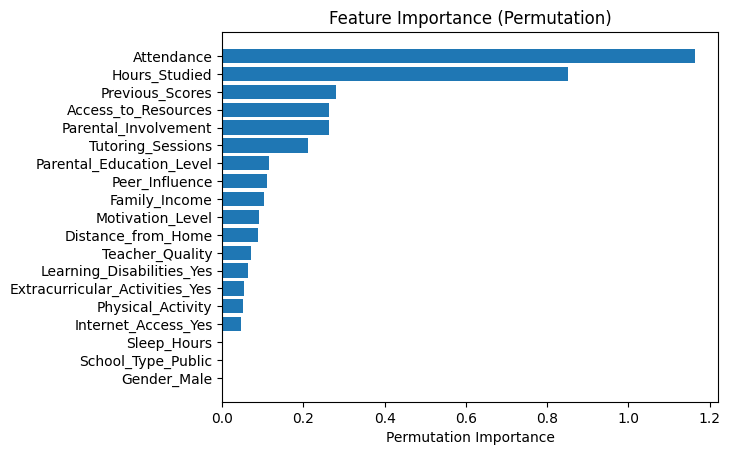

In [56]:
perm_importance = permutation_importance(final_model, X_train, y_train, scoring=quantile_scorer)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation)")
plt.show()

**Коэффициенты**

тут трудно прокомментировать)

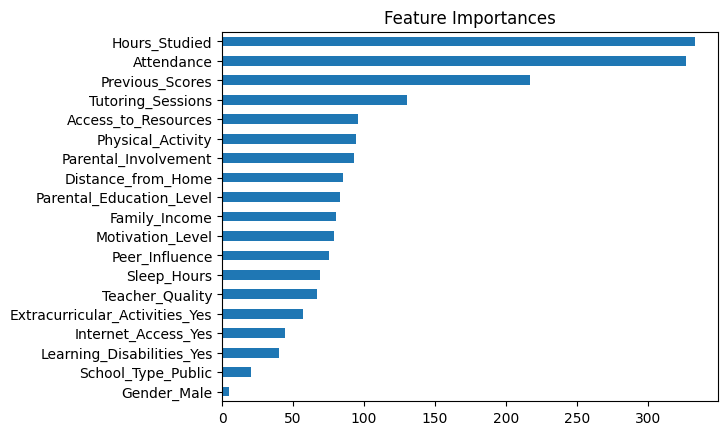

In [57]:
coefs = pd.Series(final_model.feature_importances_, index=X_train.columns)
coefs.sort_values().plot(kind='barh', title="Feature Importances")
plt.show()

**SHAP**

Для "шапа" ситуация схожая с permutation importance лишь отличается алгоритм подсчета важности
Разность в прогнозе двух моделей с n-ным признаком и без него

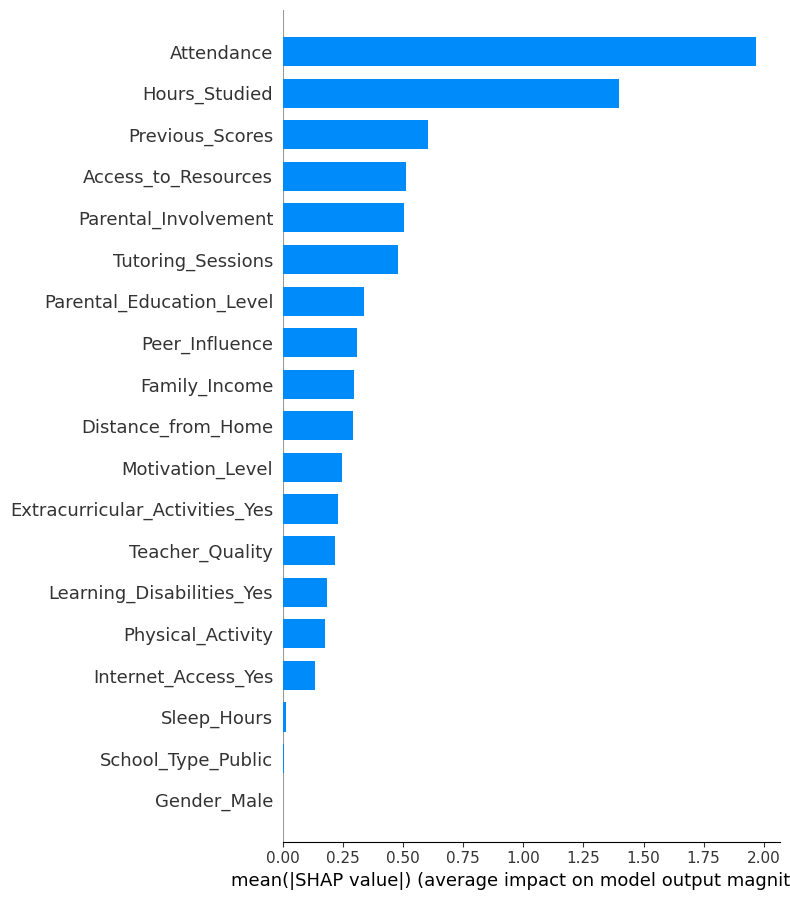

In [58]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])